In [11]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib 

sc.settings.verbosity = 3


In [12]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [13]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


# Read Data

In [15]:
from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.5, 99.5))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [16]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata = sc.read_h5ad(adata_path)

In [17]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)
    

In [18]:
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
#                'Stroma Vimentin+': 'Stroma'
#               }
rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 
               'Stroma Vimentin+': 'Stroma'
              }

# Rename a cluster
adata.obs["cluster"] = adata.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


In [19]:
adata_subset = adata[:, ['CD38', 'CD20', 'CD27']]

X = np.array(adata_subset.X)
cd38_val = X[:, 0]
cd20_val = X[:, 1]
cd27_val = X[:, 2]
gate = (cd20_val > 0) & (cd38_val<-0.4) & (cd27_val > 0)
gate = gate.astype(np.uint8)

print(np.unique(gate, return_counts=True))

adata.obs['MemoryB'] = gate
rename_dict = {0: 'Other', 
               1: 'Memory B'}

adata.obs['MemoryB'] = adata.obs['MemoryB'].map(lambda x: rename_dict.get(x, x)).astype('category')
adata.uns['MemoryB_colors'] = ['#00DBFF', '#808080']

(array([0, 1], dtype=uint8), array([946785,  53185], dtype=int64))


In [20]:
# Get adata 
phenotype_name = 'MemoryB'

sc.tl.dendrogram(adata, groupby=phenotype_name)

cluster_label_order = adata.uns[f'dendrogram_{phenotype_name}']['categories_ordered']

# Define colormap
colors = adata.uns[f"{phenotype_name}_colors"]
labels = adata.obs[phenotype_name].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)
colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`


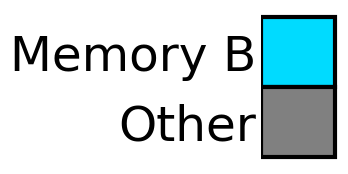

In [21]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,2))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


# Col analysis

In [22]:
import numpy as np
from scipy.ndimage import distance_transform_edt

def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask]
        for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [23]:
from skimage.measure import block_reduce
from skimage import filters 

def mean_block(img, size):
    reduced = block_reduce(img_col, block_size=(size, size), func=np.mean)
    # reduced = filters.gaussian(reduced, sigma=1)
    img_mean = np.repeat(reduced, size, axis=0)
    img_mean = np.repeat(img_mean, size, axis=1)
    img_mean[:img.shape[0], :img.shape[1]]
    img_mean = filters.gaussian(img_mean, sigma=10)
    return reduced, img_mean 

In [24]:
from skimage import morphology
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

def create_gradient(mask, size=100, n=5):
    mask = morphology.remove_small_objects(mask, min_size=10000)
    mask_grad = (mask*1).astype(np.uint8)    
    for i in range(2, n+2):
        mask_expanded = expand_labels(mask_grad, distance=size)
        mask_expanded = np.where(mask_expanded>0, mask_expanded+1, 0) 
        mask_grad = np.where(mask_grad>0, mask_grad, mask_expanded) 
    return mask_grad

In [25]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 100
color_array = plt.get_cmap('Wistia')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//4:, -1] = np.linspace(0.0,1.0, ncolors-ncolors//4)

# create a colormap object
mycmap_y= LinearSegmentedColormap.from_list(name='mycmap_y', colors=color_array)


(5000, 4000)


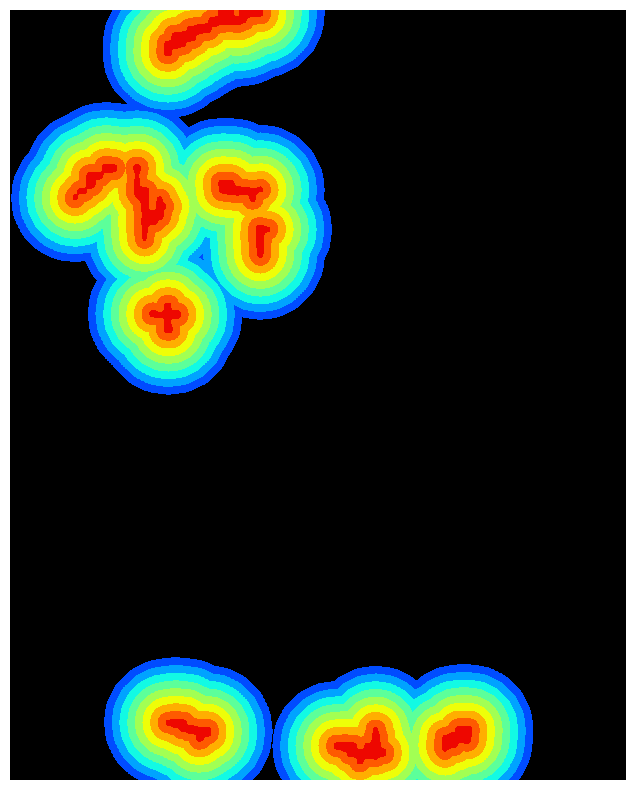

(2000, 9000)


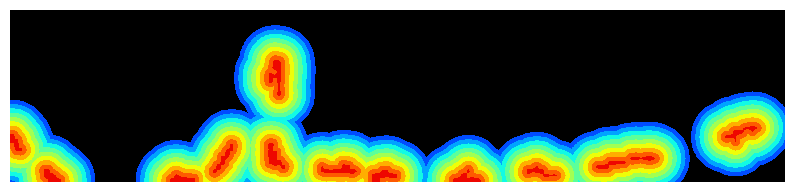

(5000, 4000)


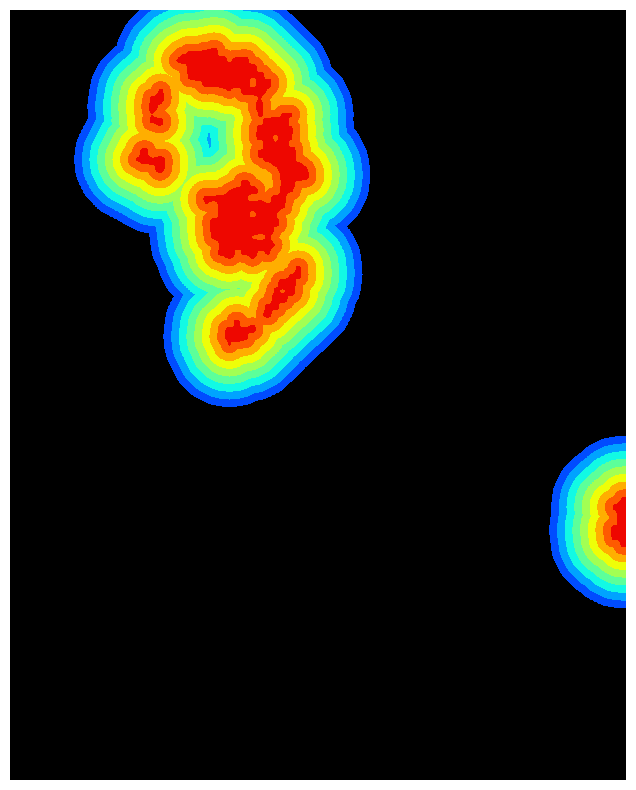

(5000, 5000)


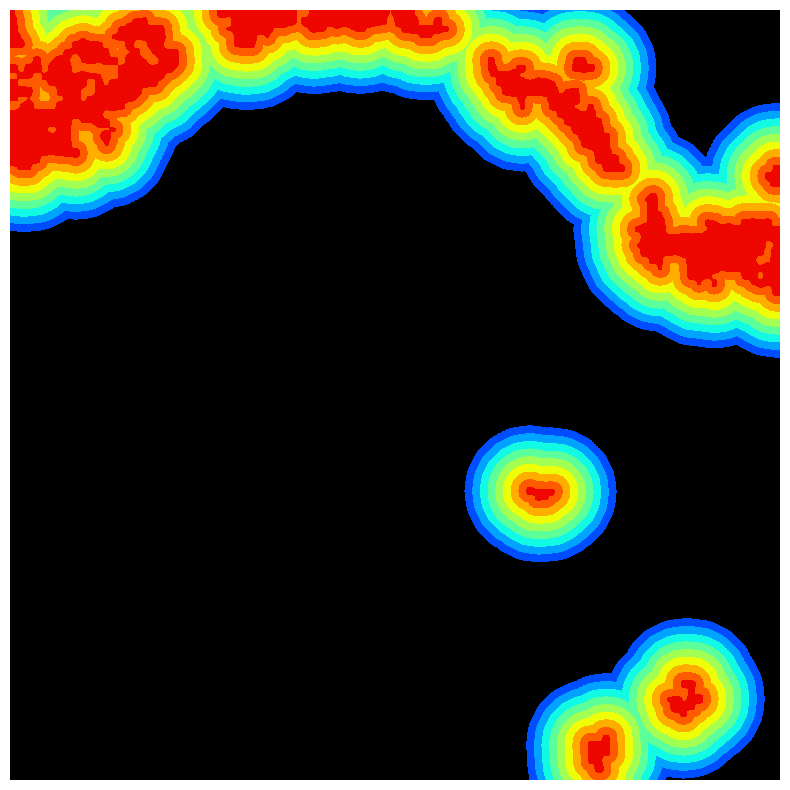

(2000, 7000)


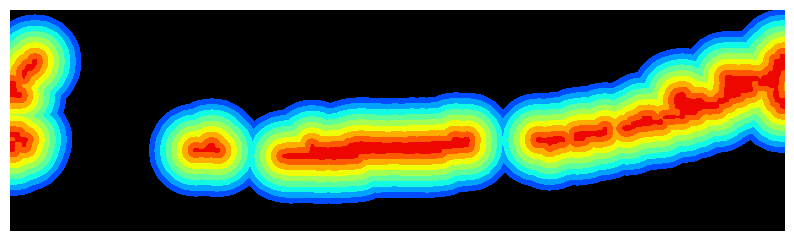

(6000, 3000)


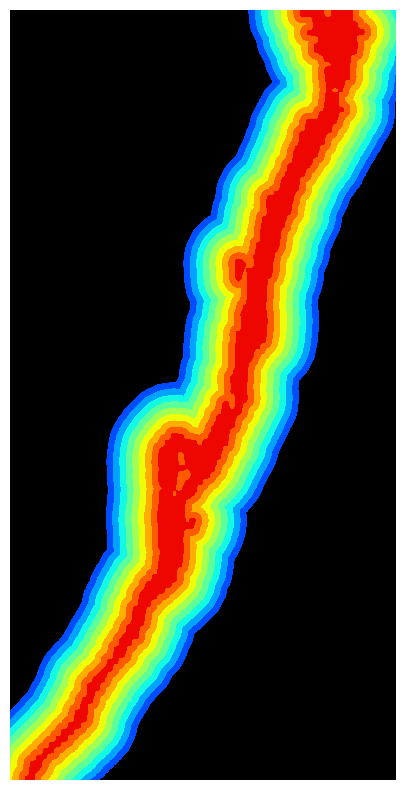

In [26]:
size = 50
thresh = 60
masks_grad = []
n = 8
pad_size = 50

# get colormap
ncolors = n+1
color_array = plt.get_cmap('jet_r')(np.linspace(0.1, 0.8, ncolors))

# change alpha values
color_array = np.vstack([np.array([0,0,0,1]), color_array])

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)

for i in range(len(donors)):
    # Read COL image and follicle mask
    img_col = imgs_col[i]
    print(img_col.shape)
    
    # Get average marker image
    _, img_mean = mean_block(img_col, size)
    img_mean_pos = img_mean > thresh
    
    # Get Gradient image
    mask_grad = create_gradient(img_mean_pos, size=pad_size, n=n)
    masks_grad.append(mask_grad)
    
    # fig, ax = plt.subplots(figsize=(10,10))
    # ax.imshow(img_mean)
    # ax.axis('off')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mask_grad, cmap=mycmap, interpolation='none')
    ax.axis('off')
    
    plt.show()


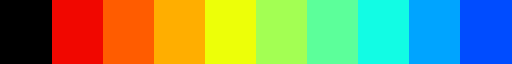

In [27]:
# create a colormap object
ListedColormap(colors=color_array)

In [28]:
dfs_pheno = []
for i in range(len(donors)):
    adata_donor = adata[adata.obs.Dataset == donors[i]]
    X = np.array(adata_donor.obsm['spatial'])[:,[1,0]].astype(int)
    df_pheno = pd.DataFrame(adata_donor.obs['MemoryB'])
    mask_grad = masks_grad[i]
    zones = mask_grad[X[:,0], X[:,1]]
    df_pheno['Zone'] = zones
    df_pheno['Donor'] = donors[i]
    dfs_pheno.append(df_pheno)

In [29]:
df_pheno = pd.concat(dfs_pheno)

In [30]:
df_count = df_pheno.groupby(['Donor', 'Zone'])[['MemoryB']].value_counts()
df_count = df_count.reset_index()
df_count.columns = ['Donor', 'Zone', 'cluster', 'Count']
df_count = df_count[df_count.Zone != 0]

In [31]:
df_count.head()

,Donor,Zone,cluster,Count
2,INT Donor B,1,Other,3370
3,INT Donor B,1,Memory B,37
4,INT Donor B,2,Other,3949
5,INT Donor B,2,Memory B,124
6,INT Donor B,3,Other,3915


In [32]:
df_pivot = df_count.pivot(index=['Zone', 'Donor'], columns='cluster', values='Count') + 1
df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)

In [33]:
df_pivot

cluster           Memory B     Other
Zone Donor                          
1    INT Donor B  0.011147  0.988853
     INT Donor E  0.018743  0.981257
     LN Donor A   0.002361  0.997639
     LN Donor E   0.003229  0.996771
     TS Donor A   0.007429  0.992571
     TS Donor E   0.016868  0.983132
2    INT Donor B  0.030675  0.969325
     INT Donor E  0.016918  0.983082
     LN Donor A   0.017332  0.982668
     LN Donor E   0.032021  0.967979
     TS Donor A   0.028950  0.971050
     TS Donor E   0.056261  0.943739
3    INT Donor B  0.040196  0.959804
     INT Donor E  0.022536  0.977464
     LN Donor A   0.064760  0.935240
     LN Donor E   0.053075  0.946925
     TS Donor A   0.037709  0.962291
     TS Donor E   0.124893  0.875107
4    INT Donor B  0.041892  0.958108
     INT Donor E  0.020592  0.979408
     LN Donor A   0.095640  0.904360
     LN Donor E   0.063764  0.936236
     TS Donor A   0.031373  0.968627
     TS Donor E   0.127538  0.872462
5    INT Donor B  0.051829  0.948171
     INT Donor E  0.022958  0.977042
     LN Donor A   0.124033  0.875967
     LN Donor E   0.066599  0.933401
     TS Donor A   0.036937  0.963063
     TS Donor E   0.152662  0.847338
6    INT Donor B  0.044063  0.955937
     INT Donor E  0.025768  0.974232
     LN Donor A   0.133372  0.866628
     LN Donor E   0.063315  0.936685
     TS Donor A   0.036530  0.963470
     TS Donor E   0.166073  0.833927
7    INT Donor B  0.032270  0.967730
     INT Donor E  0.021388  0.978612
     LN Donor A   0.113535  0.886465
     LN Donor E   0.058210  0.941790
     TS Donor A   0.037576  0.962424
     TS Donor E   0.169234  0.830766
8    INT Donor B  0.033462  0.966538
     INT Donor E  0.021311  0.978689
     LN Donor A   0.100981  0.899019
     LN Donor E   0.061037  0.938963
     TS Donor A   0.038931  0.961069
     TS Donor E   0.158047  0.841953
9    INT Donor B  0.033346  0.966654
     INT Donor E  0.015521  0.984479
     LN Donor A   0.086694  0.913306
     LN Donor E   0.058059  0.941941
     TS Donor A   0.045106  0.954894
     TS Donor E   0.155136  0.844864

In [34]:
df_subset = df_count[df_count.cluster == 'Memory B']
df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]

C:\Users\thu71\AppData\Local\Temp\ipykernel_17912\1955854894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:, 'Tissue'] = df_subset['Donor'].str[:-2]


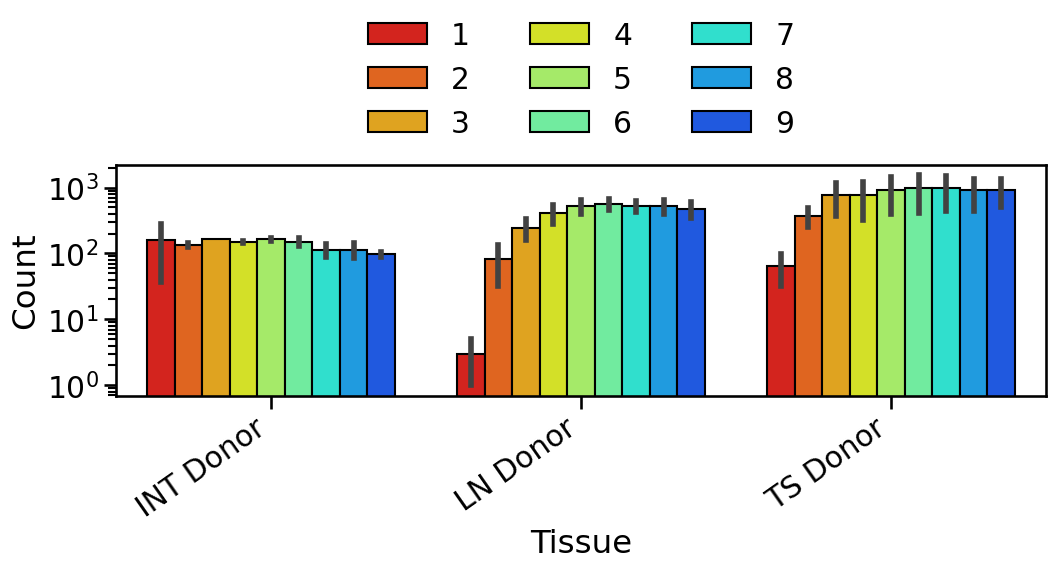

In [35]:

with sns.plotting_context('talk', font_scale=1.3):
    fig,ax = plt.subplots(figsize=(12,3))
    g = sns.barplot(data=df_subset, x="Tissue", y="Count", hue="Zone", ax=ax, palette=color_array[1:],
               edgecolor='k')
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    g.set_yscale("log")
    plt.xticks(rotation=35, ha='right')

# Plot

In [42]:
# Plot clustered cell within each mask
import matplotlib 
from PIL import Image
from skimage import measure 

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

from skimage import exposure 

def contrast_streching(img):
    p2, p98 = np.percentile(img, (1, 99))
    img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0, 255)).astype(np.uint8)
    return img

In [43]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [49]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# get colormap
ncolors = 250
color_array = plt.get_cmap('bwr')(range(ncolors))

# change alpha values
color_array[:,-1] = np.zeros(ncolors)
color_array[ncolors//2:, -1] = np.linspace(0.0, 1.0, ncolors//2)

# create a colormap object
mycmap= LinearSegmentedColormap.from_list(name='mycmap', colors=color_array)


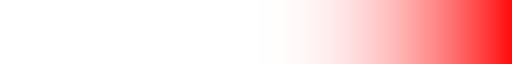

In [50]:
mycmap

In [51]:
marker = 'COL1'
imgs_col = []

# Read COL1 images
for donor in donors:
    path = p_dir / "data" / "whole_stitched"/ donor / f"{marker}.tif"
    
    img = skimage.io.imread(path)

    img_col= contrast_streching(img)
    if donor == 'INT Donor B':
        img_col = img_col[:5000, :]
    imgs_col.append(img_col)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_MemoryB']`


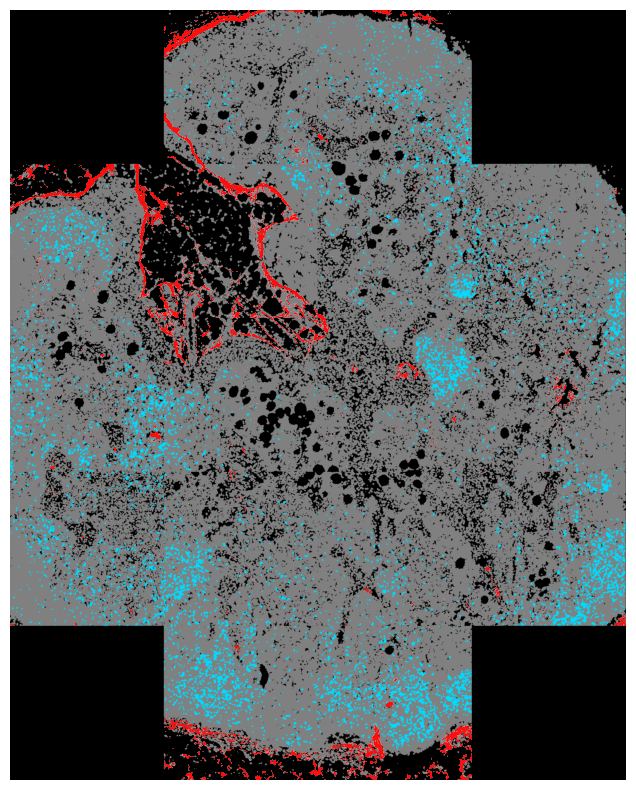

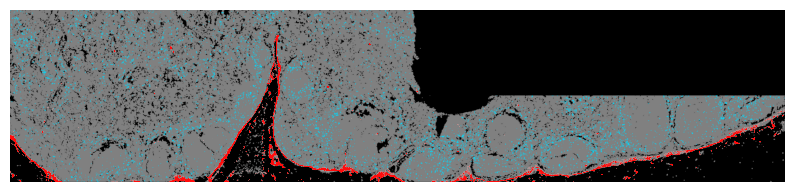

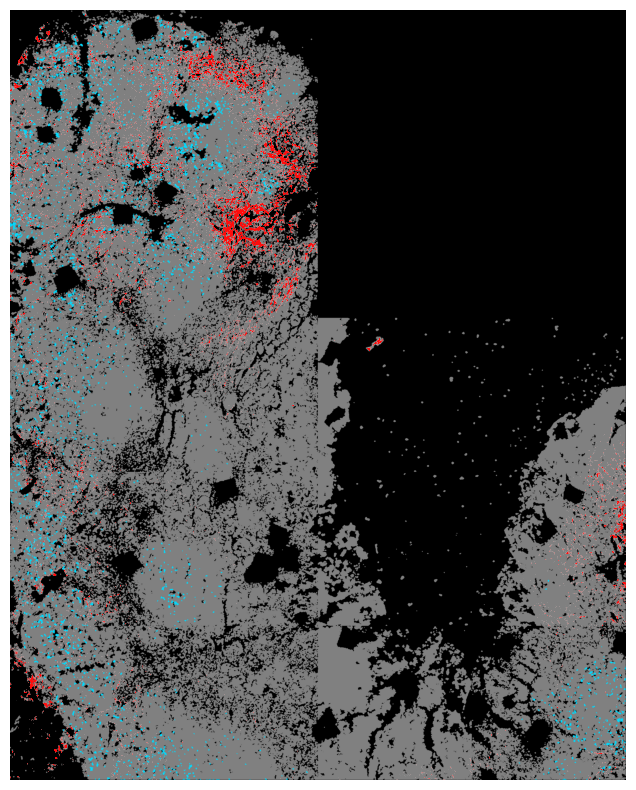

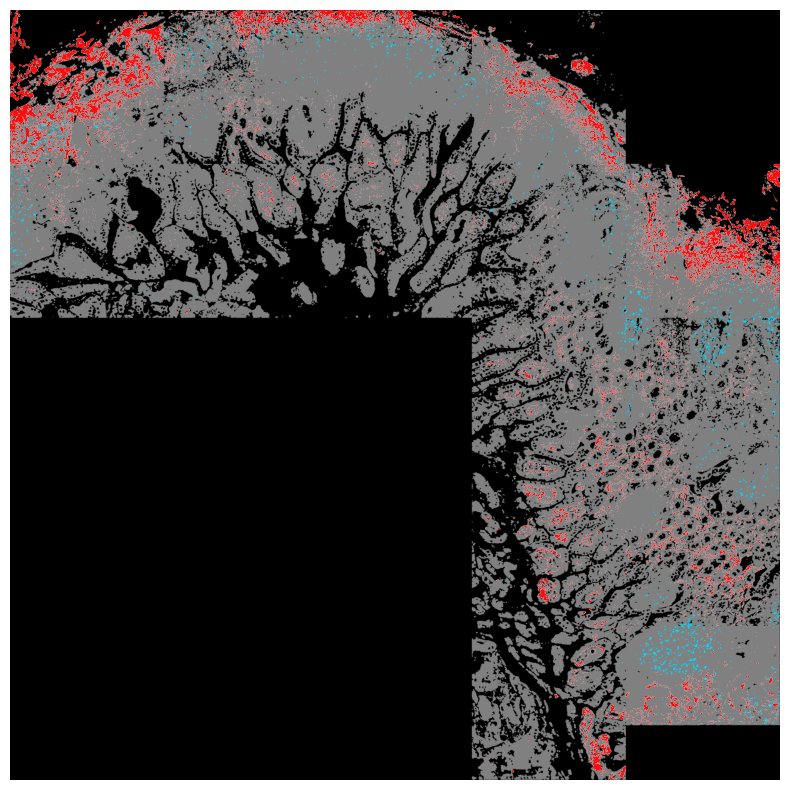

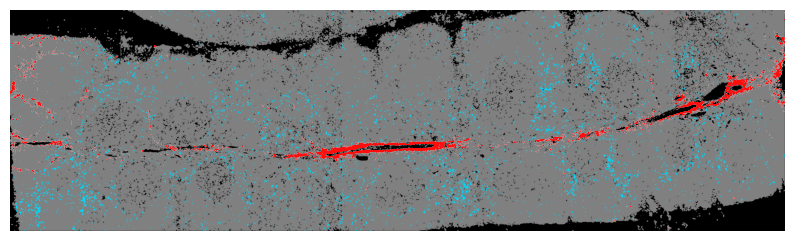

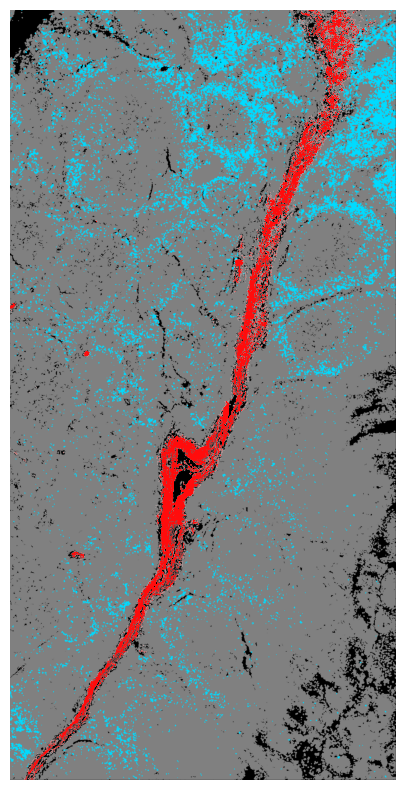

In [52]:
for i, donor in enumerate(donors):
    img_col = imgs_col[i]
# Get mask
    masks = get_masks(data_dir / "masks" / donor)

    # Get adata 
    phenotype_name = 'MemoryB'

    sc.tl.dendrogram(adata, groupby=phenotype_name)

    # Define colormap
    colors = adata.uns[f"{phenotype_name}_colors"]
    labels = adata.obs[phenotype_name].cat.categories.tolist()

    colors_rgb = []
    for color in colors:
        colors_rgb.append(matplotlib.colors.hex2color(color))
    colors_rgb = np.array(colors_rgb) * 255
    colors_rgb = colors_rgb.astype(np.uint8)
    colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}
    
    size = 1000 
    adata_donor = adata[adata.obs.Dataset == donor, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[donor])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    # mask_grad = masks_grad[donors.index(donor)]

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[donor].keys():
            continue

        # Get dataset
        adata_s = adata_donor[adata_donor.obs.ROI == i, :]
        mask = masks[str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for j, l in enumerate(labels):
            cell_id = adata_s[adata_s.obs[phenotype_name] == l].obs.Cell.to_list()
            label2cell[j] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[donor][i][0] - 1)
        x = max(0, arrangement[donor][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img
        
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_combined)
    ax.imshow(img_col, cmap=mycmap, alpha=1, vmax=150)
    ax.axis('off')
    